# <font color='blue'>Data Science Academy</font>
# <font color='blue'>Business Analytics</font>

# <font color='blue'>Capítulo 10 - Financial Analytics</font>
## <font color='blue'>Mini-Projeto 1</font>
### <font color='blue'>AI Bot Trader - Robô Investidor Para Recomendação de Compra e Venda de Criptomoedas</font>

In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.7.6


![title](imagens/mini-projeto1.png)


## Avisos Antes de Começar

- 1- Nosso objetivo aqui é didático! Não use essa aplicação para fins comerciais sem antes realizar muitos testes.
- 2- A execução do processo de treinamento pode ser bastante demorada dependendo do hardware do seu computador.
- 3- Experimente a aplicação com outras técnicas.
- 4- Este projeto é completo e funcional, mas uma versão mais avançada pode ser encontrada no curso de IA Para Finanças da Formação Engenheiro Blockchain.
- 5- Se executar muitas vezes seguidas este projeto seu acesso à API pode ser bloqueado. Estamos fornecendo o arquivo de dados extraídos no dia da gravação das aulas.

## Definição do Problema e Fonte de Dados

Leia o manual em pdf no Capítulo 10.

## Etapas do Projeto

- Parte 1 - Extração dos Dados em Tempo Real
- Parte 2 - Análise de Dados
- Parte 3 - Construção do Modelo e Otimização Bayesiana
- Parte 4 - Execução do AI Bot Trader
- Parte 5 - Conclusão e Próximos Passos

## Instalando e Carregando os Pacotes

In [2]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# !pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook.

# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
!pip install -q -U watermark

In [3]:
# CryptoCurrency eXchange Trading Library
# https://pypi.org/project/ccxt/
!pip install -q ccxt

In [4]:
# https://pypi.org/project/bayesian-optimization/
!pip install -q bayesian-optimization==1.2

In [5]:
# Imports
import csv
import ccxt
import time
import random
import types
import pkg_resources
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bayes_opt import BayesianOptimization
from pprint import pprint
from datetime import datetime
sns.set()

In [6]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

Author: Data Science Academy

pandas    : 1.2.1
csv       : 1.0
numpy     : 1.20.0
seaborn   : 0.11.1
ccxt      : 1.41.92
matplotlib: 3.3.4



## Parte 1 - Extração dos Dados em Tempo Real

### Função de Gravação dos Dados

In [7]:
# Função para salvar dados em formato csv
def grava_csv(arquivo, dados):
    
    # Abre o arquivo para escrita
    with open(arquivo, mode = 'w') as arquivo_saida:
        
        # Gera o cabeçalho
        arquivo_saida.write("Date,Open,High,Low,Close,Adj Close,Volume\n")
        
        # Grava os dados
        csv_writer = csv.writer(arquivo_saida, delimiter = ',', quotechar = '"', quoting = csv.QUOTE_MINIMAL)
        csv_writer.writerows(dados)

### Função de Conexão à Operadora de Criptomoeda

In [8]:
# Função para fazer conexão à exchange para extração dos dados
# https://www.bitmex.com/
# https://www.bitmex.com/app/apiOverview
def conecta_exchange(exchange, max_retries, symbol, timeframe, since, limit):
    
    # Zera o número de tentativas
    num_retries = 0
    
    # Tenta fazer a conexão
    try:
        num_retries += 1
        ohlcv = exchange.fetch_ohlcv(symbol, timeframe, since)
        return ohlcv
    except Exception:
        if num_retries > max_retries:
            raise

### Funções Para Extração dos Dados

In [9]:
# Função para extração dos dados
def extrai_dados(exchange, max_retries, symbol, timeframe, since, limit):
    
    # Timestamp
    earliest_timestamp = exchange.milliseconds()
    
    # Duração da janela em segundos
    timeframe_duration_in_seconds = exchange.parse_timeframe(timeframe)
    
    # Duração da janela em milisegundos
    timeframe_duration_in_ms = timeframe_duration_in_seconds * 1000
    
    # Diferença de tempo
    timedelta = limit * timeframe_duration_in_ms
    
    # Lista para os dados
    all_ohlcv = []
    
    # Loop
    while True:
        
        # Data de início para extração dos dados
        fetch_since = earliest_timestamp - timedelta
        
        # Conecta na exchange e extrai os dados
        ohlcv = conecta_exchange(exchange, max_retries, symbol, timeframe, fetch_since, limit)
        
        # Se alcançamos o limite, finaliza o loop
        if ohlcv[0][0] >= earliest_timestamp:
            break
        
        # Atualiza o tempo mais cedo
        earliest_timestamp = ohlcv[0][0]
        
        # Atualiza os dados
        all_ohlcv = ohlcv + all_ohlcv
        
        # Print do andamento
        print(len(all_ohlcv), 'registros extraídos de', exchange.iso8601(all_ohlcv[0][0]), 'a', exchange.iso8601(all_ohlcv[-1][0]))
        
        if fetch_since < since:
            break
            
    return all_ohlcv

In [10]:
# Função para extrair os dados e salvar em formato csv
def extrai_dados_para_csv(filename, exchange_id, max_retries, symbol, timeframe, since, limit):
    
    # Obtém o id da exchange com o pacote ccxt
    exchange = getattr(ccxt, exchange_id)({'enableRateLimit': True,})
    
    # Checa a consistência 
    if isinstance(since, str):
        since = exchange.parse8601(since)
    
    # Extrai o que está sendo comercializado
    exchange.load_markets()
    
    # Extrai os dados
    ohlcv = extrai_dados(exchange, max_retries, symbol, timeframe, since, limit)
    
    # Contador
    key = 0
    
    # Loop
    for item in ohlcv:
        epoch = int(item[0]) / 1000
        ohlcv[key][0] = datetime.utcfromtimestamp(epoch).strftime('%Y-%m-%d')
        ohlcv[key][5] = int(item[5])
        ohlcv[key].append(ohlcv[key][5])
        ohlcv[key][5] = ohlcv[key][4]
        key += 1
    
    # Comprimento de dados extraídos
    ohlen = len(ohlcv)
    
    # Print do andamento
    pprint("Número de Registros: " + str(ohlen))
    
    # Vamos manter um limite para os dados
    if ohlen > 399:
        ohrem = ohlen - 399
        pprint("Removendo: " + str(ohrem))
        ohlcv = ohlcv[ohrem:]
        
    # Grava os dados em csv
    grava_csv(filename, ohlcv)
    
    # Print
    print('Salvos', len(ohlcv), 'registros no arquivo', filename)

### Parâmetros Para Extração dos Dados

In [11]:
# Define os parâmetros de extração dos dados

# Exchange: https://www.bitmex.com/app/apiOverview
exchange = "bitmex"

# Símbolo da criptomoeda
simbolo = "BTC/USD"

# Janela
janela = "1d"

# Data de início
data_inicio = "2018-01-01T00:00:00Z"

# Arquivo de saída
outfile = "dados/dataset.csv"

### Extração dos Dados

In [12]:
# Executa a extração dos dados
extrai_dados_para_csv(outfile, exchange, 3, simbolo, janela, data_inicio, 100)

100 registros extraídos de 2020-11-14T00:00:00.000Z a 2021-02-21T00:00:00.000Z
200 registros extraídos de 2020-08-06T00:00:00.000Z a 2021-02-21T00:00:00.000Z
300 registros extraídos de 2020-04-28T00:00:00.000Z a 2021-02-21T00:00:00.000Z
400 registros extraídos de 2020-01-19T00:00:00.000Z a 2021-02-21T00:00:00.000Z
500 registros extraídos de 2019-10-11T00:00:00.000Z a 2021-02-21T00:00:00.000Z
600 registros extraídos de 2019-07-03T00:00:00.000Z a 2021-02-21T00:00:00.000Z
700 registros extraídos de 2019-03-25T00:00:00.000Z a 2021-02-21T00:00:00.000Z
800 registros extraídos de 2018-12-15T00:00:00.000Z a 2021-02-21T00:00:00.000Z
900 registros extraídos de 2018-09-06T00:00:00.000Z a 2021-02-21T00:00:00.000Z
1000 registros extraídos de 2018-05-29T00:00:00.000Z a 2021-02-21T00:00:00.000Z
1100 registros extraídos de 2018-02-18T00:00:00.000Z a 2021-02-21T00:00:00.000Z
1200 registros extraídos de 2017-11-10T00:00:00.000Z a 2021-02-21T00:00:00.000Z
'Número de Registros: 1200'
'Removendo: 801'
Salv

## Parte 2 - Análise de Dados

### Carregando e Explorando o Arquivo de Dados

In [13]:
# Carregando o arquivo do disco
df = pd.read_csv(outfile)

In [14]:
# Dados
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-20,8700.5,8739.0,8516.0,8632.5,8632.5,2016471911
1,2020-01-21,8632.5,8772.5,8455.0,8727.5,8727.5,1797763495
2,2020-01-22,8727.5,8796.5,8552.0,8664.5,8664.5,1313340524
3,2020-01-23,8664.5,8669.5,8283.5,8392.0,8392.0,2892720411
4,2020-01-24,8392.0,8515.0,8223.5,8425.5,8425.5,2520283967


In [15]:
# Shape
df.shape

(399, 7)

In [16]:
# Dados de fechamento
close = df.Close.values.tolist()

In [17]:
# Outros parâmetros para a versão base do modelo
window_size = 30
skip = 5
l = len(close) - 1

## Parte 3 - Construção do Modelo e Otimização Bayesiana

A parte 3 considera que você tem algum conhecimento em Aprendizado Por Reforço. Esse conhecimento pode ser obtido no curso de Deep Learning II em nível avançado ou em nível básico no curso gratuito de Python Fundamentos aqui na DSA.

### Estratégia de Treinamento

https://arxiv.org/abs/1712.06560

https://openai.com/blog/evolution-strategies/

https://gist.github.com/karpathy/77fbb6a8dac5395f1b73e7a89300318d

http://www.deeplearningbook.com.br/

In [18]:
# Classe para a estratégia de treinamento
# Usamos Deep Evolution Strategy do OpenAI
class PoliticaTrader:

    # Inputs
    inputs = None

    # Construtor
    def __init__(self, weights, reward_function, population_size, sigma, learning_rate):
        
        # Inicializa os atributos da classe
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate

    # Obtém o peso a partir da população
    def get_weights_population(self, weights, population):
        
        # Lista para os pesos
        weights_population = []
        
        # Loop pela população
        for index, i in enumerate(population):
            jittered = self.sigma * i
            weights_population.append(weights[index] + jittered)
        
        return weights_population

    # Obtém os pesos
    def get_weights(self):
        return self.weights

    # Treinamento
    def treinamento(self, epoch = 100, print_every = 1):
        
        # Time
        lasttime = time.time()
        
        # Loop pelas épocas
        for i in range(epoch):
            
            # Lista para a população
            population = []
            
            # Recompensas
            rewards = np.zeros(self.population_size)
            
            # Loop pelo population_size
            for k in range(self.population_size):
                
                x = []
                
                # Loop
                for w in self.weights:
                    x.append(np.random.randn(*w.shape))
                    
                population.append(x)
            
            # Loop
            for k in range(self.population_size):
                
                weights_population = self.get_weights_population(self.weights, population[k])
                rewards[k] = self.reward_function(weights_population)
            
            # Recompensas
            rewards = (rewards - np.mean(rewards)) / np.std(rewards)
            
            # Loop
            for index, w in enumerate(self.weights):
                A = np.array([p[index] for p in population])
                
                # Pesos da rede neural 
                self.weights[index] = (w + self.learning_rate / (self.population_size * self.sigma) * np.dot(A.T, rewards).T)
            
            if (i + 1) % print_every == 0:
                print('Iteração %d. Recompensa: %f' % (i + 1, self.reward_function(self.weights)))
        
        print('Tempo Total de Treinamento:', time.time() - lasttime, 'segundos')

### Arquitetura do Modelo de Rede Neural

In [19]:
# Classe do Modelo
class Modelo:
    
    # Método construtor
    def __init__(self, input_size, layer_size, output_size):
        
        self.weights = [np.random.randn(input_size, layer_size),
                        np.random.randn(layer_size, output_size),
                        np.random.randn(layer_size, 1),
                        np.random.randn(1, layer_size),]

    # Função para previsão
    def predict(self, inputs):
        
        # Feed forward
        feed = np.dot(inputs, self.weights[0]) + self.weights[-1]
        
        # Decisão de compra (previsão)
        decision = np.dot(feed, self.weights[1])
        
        # Compra (decisão)
        buy = np.dot(feed, self.weights[2])
        
        return decision, buy

    def get_weights(self):
        return self.weights

    def set_weights(self, weights):
        self.weights = weights

### Configuração do AI Bot Trader

In [20]:
# Função para obter o estado dos dados
def get_state(data, t, n):
    d = t - n + 1
    block = data[d : t + 1] if d >= 0 else -d * [data[0]] + data[0 : t + 1]
    res = []
    for i in range(n - 1):
        res.append(block[i + 1] - block[i])
    return np.array([res])

In [21]:
# Classe para o agente inteligente (Trader)
class Trader:
    
    # Método construtor
    def __init__(self, population_size, sigma, learning_rate, model, money, max_buy, max_sell, skip, window_size,):
        
        # Inicializa os atributos
        self.window_size = window_size
        self.skip = skip
        self.POPULATION_SIZE = population_size
        self.SIGMA = sigma
        self.LEARNING_RATE = learning_rate
        self.model = model
        self.initial_money = money
        self.max_buy = max_buy
        self.max_sell = max_sell
        self.es = PoliticaTrader(self.model.get_weights(),
                                 self.get_reward,
                                 self.POPULATION_SIZE,
                                 self.SIGMA,
                                 self.LEARNING_RATE,)

    # Método de ação
    def agir(self, sequence):
        decision, buy = self.model.predict(np.array(sequence))
        return np.argmax(decision[0]), int(buy[0])

    # Método para obter recompensa
    def get_reward(self, weights):
        
        # Valor inicial investido
        initial_money = self.initial_money
        starting_money = initial_money
        
        # Pesos
        self.model.weights = weights
        
        # Estado
        state = get_state(close, 0, self.window_size + 1)
        
        # Objetos de controle
        inventory = []
        quantity = 0
        
        # Loop
        for t in range(0, l, self.skip):
            
            # Ação e compra/venda
            action, buy = self.agir(state)
            
            # Próximo estado
            next_state = get_state(close, t + 1, self.window_size + 1)
            
            # Verifica ação e valor inicial investido
            if action == 1 and initial_money >= close[t]:
                if buy < 0:
                    buy = 1
                if buy > self.max_buy:
                    buy_units = self.max_buy
                else:
                    buy_units = buy
                    
                total_buy = buy_units * close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
            
            elif action == 2 and len(inventory) > 0:
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity
                    
                quantity -= sell_units
                total_sell = sell_units * close[t]
                initial_money += total_sell

            # Próximo estado
            state = next_state
        
        return ((initial_money - starting_money) / starting_money) * 100

    # Treinamento do Trader
    def fit(self, iterations, checkpoint):
        self.es.treinamento(iterations, print_every = checkpoint)

    # Método para recomendação
    def investir(self):
        
        # Valor inicial
        initial_money = self.initial_money
        starting_money = initial_money
        
        # Estado
        state = get_state(close, 0, self.window_size + 1)
        
        # Listas de controle        
        states_sell = []
        states_buy = []
        inventory = []
        quantity = 0
        
        # Loop
        for t in range(0, l, self.skip):
            
            # Ação e compra
            action, buy = self.agir(state)
            
            # Próximo estado
            next_state = get_state(close, t + 1, self.window_size + 1)
            
            # Verifica ação e valor inicial investido
            if action == 1 and initial_money >= close[t]:
                if buy < 0:
                    buy = 1
                if buy > self.max_buy:
                    buy_units = self.max_buy
                else:
                    buy_units = buy
                
                total_buy = buy_units * close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
                states_buy.append(t)
                
                print('Dia %d: comprar %d unidades ao preço de %f, saldo total %f' % (t, buy_units, total_buy, initial_money))
            
            elif action == 2 and len(inventory) > 0:
                bought_price = inventory.pop(0)
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity
                if sell_units < 1:
                    continue
                    
                quantity -= sell_units
                total_sell = sell_units * close[t]
                initial_money += total_sell
                states_sell.append(t)
                
                try:
                    invest = ((total_sell - bought_price) / bought_price) * 100
                except:
                    invest = 0
                
                print('Dia %d, vender %d unidades ao preço de %f, investimento %f %%, saldo total %f,' % (t, sell_units, total_sell, invest, initial_money))
            
            # Próximo estado
            state = next_state

        # Investimento
        invest = ((initial_money - starting_money) / starting_money) * 100
        
        print('\nGanho Total %f, Valor Total Investido %f' % (initial_money - starting_money, invest))
        
        plt.figure(figsize = (20, 10))
        plt.plot(close, label = 'Valor Real de Fechamento', c = 'g')
        plt.plot(close, 'X', label = 'Previsão de Compra', markevery = states_buy, c = 'b')
        plt.plot(close, 'o', label = 'Previsão de Venda', markevery = states_sell, c = 'r')
        plt.legend()
        plt.show()

### Funções Para Buscar o Melhor Trader

In [22]:
# Função para encontrar o melhor trader
def melhor_trader(window_size, skip, population_size, sigma, learning_rate, size_network):
    
    # Cria o modelo
    model = Modelo(window_size, size_network, 3)
    
    # Cria o trader
    trader = Trader(population_size, sigma, learning_rate, model, 10000, 5, 5, skip, window_size,)
    
    # Treinamento
    try:
        trader.fit(100, 1000)
        return trader.es.reward_function(trader.es.weights)
    except:
        return 0

In [23]:
# Função para encontrar o melhor trader de acordo com os hiperparâmetros
def busca_melhor_trader(window_size, skip, population_size, sigma, learning_rate, size_network):
    
    # Variável global
    global accbest
    
    # Hiperparâmetros
    param = {'window_size': int(np.around(window_size)),
             'skip': int(np.around(skip)),
             'population_size': int(np.around(population_size)),
             'sigma': max(min(sigma, 1), 0.0001),
             'learning_rate': max(min(learning_rate, 0.5), 0.000001),
             'size_network': int(np.around(size_network)),}
    
    print('\nBuscando Parâmetros %s' % (param))
    
    # Investimento feito pelo melhor trader
    investment = melhor_trader(**param)
    
    print('Após 100 iterações o investimento foi de %f' % (investment))
        
    return investment

### Otimização Bayesiana Para os Hiperparâmetros do Modelo

In [24]:
# Modelo para otimização bayesiana de hiperparâmetros
otimizacao_bayesiana = BayesianOptimization(busca_melhor_trader, {'window_size': (2, 50),
                                                                  'skip': (1, 15),
                                                                  'population_size': (1, 50),
                                                                  'sigma': (0.01, 0.99),
                                                                  'learning_rate': (0.000001, 0.49),
                                                                  'size_network': (10, 1000),},)

In [25]:
%%time
otimizacao_bayesiana.maximize(init_points = 30, n_iter = 50, acq = 'ei', xi = 0.0)

|   iter    |  target   | learni... | popula... |   sigma   | size_n... |   skip    | window... |
-------------------------------------------------------------------------------------------------

Buscando Parâmetros {'window_size': 29, 'skip': 14, 'population_size': 2, 'sigma': 0.9147978808845331, 'learning_rate': 0.46302104146463996, 'size_network': 580}
Após 100 iterações o investimento foi de 0.000000
|  1        |  0.0      |  0.463    |  2.369    |  0.9148   |  579.8    |  13.89    |  28.71    |

Buscando Parâmetros {'window_size': 20, 'skip': 3, 'population_size': 50, 'sigma': 0.33590155313988684, 'learning_rate': 0.22740436817592036, 'size_network': 502}


/Users/dmpm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in true_divide


Tempo Total de Treinamento: 20.774590015411377 segundos
Após 100 iterações o investimento foi de 3637.155000
|  2        |  3.637e+0 |  0.2274   |  49.68    |  0.3359   |  501.7    |  3.076    |  20.45    |

Buscando Parâmetros {'window_size': 26, 'skip': 3, 'population_size': 6, 'sigma': 0.3055042537158398, 'learning_rate': 0.06304035751952769, 'size_network': 869}
Tempo Total de Treinamento: 2.8756918907165527 segundos
Após 100 iterações o investimento foi de 2783.600000
|  3        |  2.784e+0 |  0.06304  |  6.028    |  0.3055   |  869.0    |  2.768    |  25.97    |

Buscando Parâmetros {'window_size': 49, 'skip': 14, 'population_size': 11, 'sigma': 0.37019722755867673, 'learning_rate': 0.34759375779405116, 'size_network': 936}
Tempo Total de Treinamento: 3.4725208282470703 segundos
Após 100 iterações o investimento foi de 2358.925000
|  4        |  2.359e+0 |  0.3476   |  10.84    |  0.3702   |  935.6    |  13.85    |  49.3     |

Buscando Parâmetros {'window_size': 23, 'skip': 4, 

Tempo Total de Treinamento: 8.302157163619995 segundos
Após 100 iterações o investimento foi de 2705.375000
|  23       |  2.705e+0 |  0.3544   |  36.4     |  0.8786   |  822.4    |  8.906    |  27.0     |

Buscando Parâmetros {'window_size': 47, 'skip': 13, 'population_size': 41, 'sigma': 0.8029674781772999, 'learning_rate': 0.4512727838834015, 'size_network': 987}
Tempo Total de Treinamento: 14.712478876113892 segundos
Após 100 iterações o investimento foi de 2448.150000
|  24       |  2.448e+0 |  0.4513   |  40.8     |  0.803    |  986.8    |  12.6     |  46.55    |

Buscando Parâmetros {'window_size': 24, 'skip': 4, 'population_size': 26, 'sigma': 0.2352086244347335, 'learning_rate': 0.3527832257085009, 'size_network': 701}
Tempo Total de Treinamento: 9.68520975112915 segundos
Após 100 iterações o investimento foi de 2984.580000
|  25       |  2.985e+0 |  0.3528   |  26.0     |  0.2352   |  701.2    |  4.334    |  23.92    |

Buscando Parâmetros {'window_size': 6, 'skip': 9, 'popul

/Users/dmpm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in true_divide


Após 100 iterações o investimento foi de 0.000000
|  41       |  0.0      |  0.3089   |  6.135    |  0.2995   |  660.9    |  11.36    |  15.82    |

Buscando Parâmetros {'window_size': 13, 'skip': 8, 'population_size': 44, 'sigma': 0.9145212193523838, 'learning_rate': 0.10689725061072819, 'size_network': 363}
Tempo Total de Treinamento: 5.320698261260986 segundos
Após 100 iterações o investimento foi de 1982.530000
|  42       |  1.983e+0 |  0.1069   |  44.31    |  0.9145   |  362.8    |  8.032    |  12.95    |

Buscando Parâmetros {'window_size': 13, 'skip': 6, 'population_size': 19, 'sigma': 0.19713676508908703, 'learning_rate': 0.1229871420822486, 'size_network': 251}
Tempo Total de Treinamento: 2.5031540393829346 segundos
Após 100 iterações o investimento foi de 3019.150000
|  43       |  3.019e+0 |  0.123    |  18.8     |  0.1971   |  250.9    |  5.853    |  13.35    |

Buscando Parâmetros {'window_size': 40, 'skip': 2, 'population_size': 44, 'sigma': 0.2449568486391213, 'learning

Tempo Total de Treinamento: 6.851206064224243 segundos
Após 100 iterações o investimento foi de 2684.615000
|  61       |  2.685e+0 |  0.2538   |  25.37    |  0.7439   |  701.6    |  5.394    |  20.59    |

Buscando Parâmetros {'window_size': 35, 'skip': 6, 'population_size': 46, 'sigma': 0.14016409489632042, 'learning_rate': 0.17945552161044434, 'size_network': 222}
Tempo Total de Treinamento: 8.903323888778687 segundos
Após 100 iterações o investimento foi de 2883.465000
|  62       |  2.883e+0 |  0.1795   |  46.23    |  0.1402   |  221.6    |  6.0      |  34.7     |

Buscando Parâmetros {'window_size': 39, 'skip': 4, 'population_size': 49, 'sigma': 0.9275408738920986, 'learning_rate': 0.18284034023952153, 'size_network': 226}
Tempo Total de Treinamento: 13.90502405166626 segundos
Após 100 iterações o investimento foi de 2392.555000
|  63       |  2.393e+0 |  0.1828   |  49.1     |  0.9275   |  226.3    |  4.488    |  39.47    |

Buscando Parâmetros {'window_size': 48, 'skip': 4, 'po

/Users/dmpm/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in true_divide


Após 100 iterações o investimento foi de 0.000000
|  78       |  0.0      |  0.3128   |  33.33    |  0.06498  |  690.2    |  3.221    |  48.27    |

Buscando Parâmetros {'window_size': 49, 'skip': 2, 'population_size': 37, 'sigma': 0.1774624031811585, 'learning_rate': 0.3415200894980094, 'size_network': 687}
Tempo Total de Treinamento: 30.146279096603394 segundos
Após 100 iterações o investimento foi de 3457.135000
|  79       |  3.457e+0 |  0.3415   |  36.67    |  0.1775   |  687.3    |  1.697    |  49.01    |

Buscando Parâmetros {'window_size': 37, 'skip': 5, 'population_size': 44, 'sigma': 0.4957932258903227, 'learning_rate': 0.08544212435850908, 'size_network': 227}
Tempo Total de Treinamento: 10.05056619644165 segundos
Após 100 iterações o investimento foi de 2713.325000
|  80       |  2.713e+0 |  0.08544  |  43.74    |  0.4958   |  226.9    |  4.525    |  37.31    |
CPU times: user 37min 48s, sys: 5min 10s, total: 42min 58s
Wall time: 15min 50s


In [26]:
type(otimizacao_bayesiana)

bayes_opt.bayesian_optimization.BayesianOptimization

In [27]:
# Visualiza o resultado
otimizacao_bayesiana.res

[{'target': 0.0,
  'params': {'learning_rate': 0.46302104146463996,
   'population_size': 2.368547176120046,
   'sigma': 0.9147978808845331,
   'size_network': 579.7969364038205,
   'skip': 13.89360134201776,
   'window_size': 28.707858935971696}},
 {'target': 3637.1549999999997,
  'params': {'learning_rate': 0.22740436817592036,
   'population_size': 49.67717503462105,
   'sigma': 0.33590155313988684,
   'size_network': 501.6804930205126,
   'skip': 3.076363850175786,
   'window_size': 20.448817015903746}},
 {'target': 2783.6,
  'params': {'learning_rate': 0.06304035751952769,
   'population_size': 6.028469230305342,
   'sigma': 0.3055042537158398,
   'size_network': 869.0139854939724,
   'skip': 2.7683623109247915,
   'window_size': 25.96698698799558}},
 {'target': 2358.925,
  'params': {'learning_rate': 0.34759375779405116,
   'population_size': 10.836831555602771,
   'sigma': 0.37019722755867673,
   'size_network': 935.6399228948774,
   'skip': 13.847889846204906,
   'window_size':

Vamos obter o maior valor para cada hiperparâmetro.

In [28]:
max([dic['target'] for dic in otimizacao_bayesiana.res])

5831.645

In [29]:
[dic['params'] for dic in otimizacao_bayesiana.res]

[{'learning_rate': 0.46302104146463996,
  'population_size': 2.368547176120046,
  'sigma': 0.9147978808845331,
  'size_network': 579.7969364038205,
  'skip': 13.89360134201776,
  'window_size': 28.707858935971696},
 {'learning_rate': 0.22740436817592036,
  'population_size': 49.67717503462105,
  'sigma': 0.33590155313988684,
  'size_network': 501.6804930205126,
  'skip': 3.076363850175786,
  'window_size': 20.448817015903746},
 {'learning_rate': 0.06304035751952769,
  'population_size': 6.028469230305342,
  'sigma': 0.3055042537158398,
  'size_network': 869.0139854939724,
  'skip': 2.7683623109247915,
  'window_size': 25.96698698799558},
 {'learning_rate': 0.34759375779405116,
  'population_size': 10.836831555602771,
  'sigma': 0.37019722755867673,
  'size_network': 935.6399228948774,
  'skip': 13.847889846204906,
  'window_size': 49.29730304942034},
 {'learning_rate': 0.4189139792439613,
  'population_size': 15.868399613121015,
  'sigma': 0.13244632974457216,
  'size_network': 212.029

In [30]:
max([d['learning_rate'] for d in [dic['params'] for dic in otimizacao_bayesiana.res]])

0.4738976217098798

In [31]:
max([d['population_size'] for d in [dic['params'] for dic in otimizacao_bayesiana.res]])

49.84444009085645

In [32]:
max([d['sigma'] for d in [dic['params'] for dic in otimizacao_bayesiana.res]])

0.9648962582006283

In [33]:
max([d['size_network'] for d in [dic['params'] for dic in otimizacao_bayesiana.res]])

986.7986974229476

In [34]:
max([d['skip'] for d in [dic['params'] for dic in otimizacao_bayesiana.res]])

14.843784035643452

In [35]:
max([d['window_size'] for d in [dic['params'] for dic in otimizacao_bayesiana.res]])

49.65519003432752

## Parte 4 - Execução do AI Bot Trader

### Execução do AI Bot Trader - Modelo Base

In [36]:
%%time
melhor_trader(window_size = 30, 
              skip = 1, 
              population_size = 15, 
              sigma = 0.1, 
              learning_rate = 0.03, 
              size_network = 500)

Tempo Total de Treinamento: 16.505861043930054 segundos
CPU times: user 55.9 s, sys: 8.66 s, total: 1min 4s
Wall time: 16.5 s


2416.06

In [37]:
# Cria o modelo
modelo_base = Modelo(input_size = 30, layer_size = 500, output_size = 3)

In [38]:
# Cria o trader base
trader_base = Trader(population_size = 15, 
                     sigma = 0.1, 
                     learning_rate = 0.03, 
                     model = modelo_base, 
                     money = 10000, 
                     max_buy = 5, 
                     max_sell = 5, 
                     skip = 1, 
                     window_size = 30)

Aqui treinamos o trader!

In [39]:
%%time
trader_base.fit(500, 100)

Iteração 100. Recompensa: 3061.365000
Iteração 200. Recompensa: 3168.340000
Iteração 300. Recompensa: 3095.955000
Iteração 400. Recompensa: 2941.475000
Iteração 500. Recompensa: 3113.785000
Tempo Total de Treinamento: 85.77970170974731 segundos
CPU times: user 4min 45s, sys: 45.8 s, total: 5min 31s
Wall time: 1min 25s


Dia 3: comprar 5 unidades ao preço de 41960.000000, saldo total -31960.000000
Dia 9, vender 5 unidades ao preço de 46472.500000, investimento 10.754290 %, saldo total 14512.500000,
Dia 10: comprar 1 unidades ao preço de 9510.000000, saldo total 5002.500000
Dia 23, vender 1 unidades ao preço de 10363.000000, investimento 8.969506 %, saldo total 15365.500000,
Dia 24: comprar 1 unidades ao preço de 10241.000000, saldo total 5124.500000
Dia 28, vender 1 unidades ao preço de 9715.000000, investimento -5.136217 %, saldo total 14839.500000,
Dia 31: comprar 5 unidades ao preço de 48037.500000, saldo total -33198.000000
Dia 35, vender 5 unidades ao preço de 48302.500000, investimento 0.551652 %, saldo total 15104.500000,
Dia 37: comprar 1 unidades ao preço de 8780.000000, saldo total 6324.500000
Dia 40, vender 1 unidades ao preço de 8531.500000, investimento -2.830296 %, saldo total 14856.000000,
Dia 41: comprar 1 unidades ao preço de 8532.500000, saldo total 6323.500000
Dia 44, vender 1 unidad

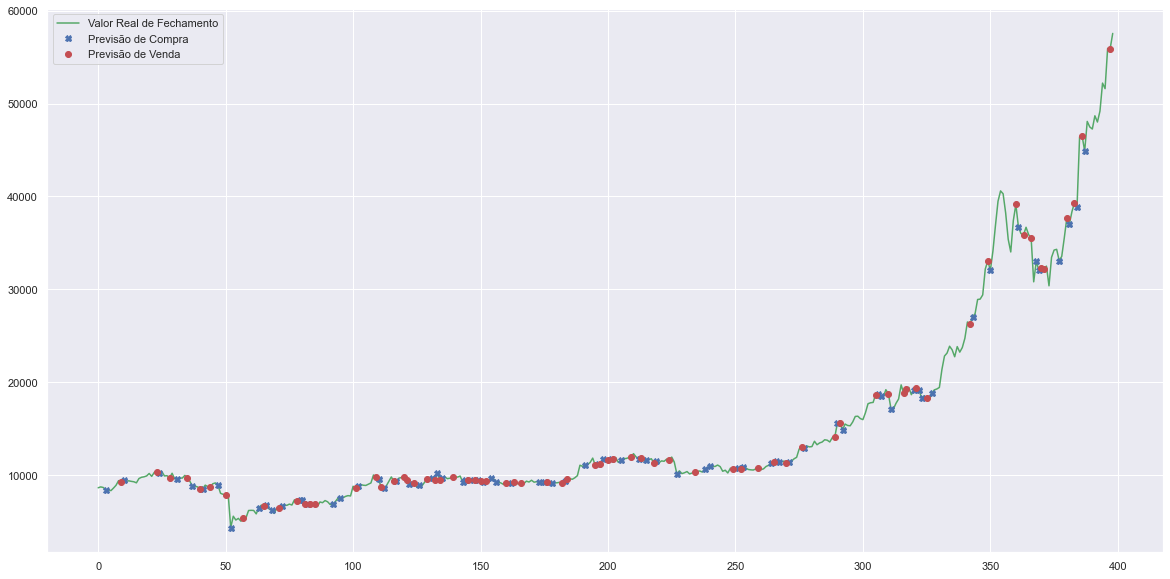

In [40]:
# Recomendações
trader_base.investir()

### Execução do AI Bot Trader - Modelo Otimizado

In [41]:
%%time
melhor_trader(window_size = int(np.around(max([d['window_size'] for d in [dic['params'] for dic in otimizacao_bayesiana.res]]))), 
              skip = int(np.around(max([d['skip'] for d in [dic['params'] for dic in otimizacao_bayesiana.res]]))), 
              population_size = int(max([d['population_size'] for d in [dic['params'] for dic in otimizacao_bayesiana.res]])), 
              sigma = max([d['sigma'] for d in [dic['params'] for dic in otimizacao_bayesiana.res]]), 
              learning_rate = max([d['learning_rate'] for d in [dic['params'] for dic in otimizacao_bayesiana.res]]), 
              size_network = int(np.around(max([d['size_network'] for d in [dic['params'] for dic in otimizacao_bayesiana.res]]))))

Tempo Total de Treinamento: 16.149183988571167 segundos
CPU times: user 49 s, sys: 8.16 s, total: 57.1 s
Wall time: 16.2 s


1936.755

In [42]:
%%time
modelo_otim = Modelo(input_size = int(np.around(max([d['window_size'] for d in [dic['params'] for dic in otimizacao_bayesiana.res]]))), 
                     layer_size = int(np.around(max([d['size_network'] for d in [dic['params'] for dic in otimizacao_bayesiana.res]]))), 
                     output_size = 3)

CPU times: user 6.49 ms, sys: 2.68 ms, total: 9.17 ms
Wall time: 2.29 ms


In [43]:
# Cria o trader com otimização
trader_otim = Trader(population_size = int(np.around(max([d['population_size'] for d in [dic['params'] for dic in otimizacao_bayesiana.res]]))), 
                     sigma = max([d['sigma'] for d in [dic['params'] for dic in otimizacao_bayesiana.res]]), 
                     learning_rate = max([d['learning_rate'] for d in [dic['params'] for dic in otimizacao_bayesiana.res]]), 
                     model = modelo_otim, 
                     money = 10000, 
                     max_buy = 5, 
                     max_sell = 5, 
                     skip = int(np.around(max([d['skip'] for d in [dic['params'] for dic in otimizacao_bayesiana.res]]))), 
                     window_size = int(np.around(max([d['window_size'] for d in [dic['params'] for dic in otimizacao_bayesiana.res]]))))

Aqui treinamos o trader!

In [44]:
%%time
trader_otim.fit(500, 100)

Iteração 100. Recompensa: 2318.550000
Iteração 200. Recompensa: 2435.025000
Iteração 300. Recompensa: 2435.025000
Iteração 400. Recompensa: 2450.430000
Iteração 500. Recompensa: 2486.895000
Tempo Total de Treinamento: 83.67513298988342 segundos
CPU times: user 4min 9s, sys: 42.4 s, total: 4min 51s
Wall time: 1min 23s


Dia 0: comprar 5 unidades ao preço de 43162.500000, saldo total -33162.500000
Dia 30, vender 5 unidades ao preço de 47982.500000, investimento 11.167101 %, saldo total 14820.000000,
Dia 75: comprar 1 unidades ao preço de 6875.000000, saldo total 7945.000000
Dia 90: comprar 5 unidades ao preço de 35627.500000, saldo total -27682.500000
Dia 120, vender 5 unidades ao preço de 48932.500000, investimento 611.745455 %, saldo total 21250.000000,
Dia 165: comprar 5 unidades ao preço de 45277.500000, saldo total -24027.500000
Dia 210, vender 5 unidades ao preço de 61542.500000, investimento 72.738755 %, saldo total 37515.000000,
Dia 225, vender 1 unidades ao preço de 11937.000000, investimento -73.635912 %, saldo total 49452.000000,
Dia 255: comprar 5 unidades ao preço de 53035.000000, saldo total -3583.000000
Dia 315, vender 5 unidades ao preço de 98572.500000, investimento 85.863109 %, saldo total 94989.500000,
Dia 330: comprar 5 unidades ao preço de 97195.000000, saldo total -2205.500000
Dia

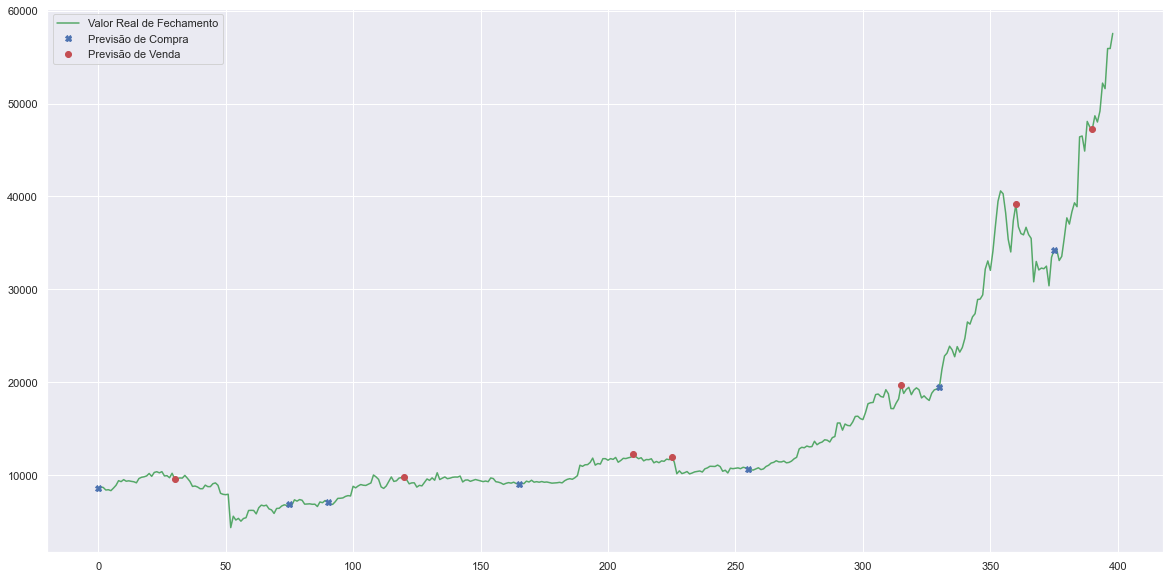

CPU times: user 467 ms, sys: 77.8 ms, total: 545 ms
Wall time: 282 ms


In [45]:
%%time
trader_otim.investir()

## Parte 5 - Conclusão, Lições Aprendidas e Próximos Passos

- Um projeto como esse é complexo e requer conhecimento avançado.
- Nosso Trader demonstrou bons resultados com baixo volume de dados. Teríamos que validar isso com volumes de dados maiores.
- Diferentes políticas podem ser usadas para treinar o Trader e essa é uma decisão humana.
- Diferentes arquiteturas podem ser usadas no modelo e essa é uma decisão humana.
- Todas as técnicas usadas neste projeto podem ser refinadas com procedimentos mais avançados, tornando o AI Bot Trader ainda mais preciso.

# Fim